---
title: "Modelo LDA para la clasificación de contratos de obra"
author: "Mauricio Roverssi Alvarado"
date: "2023-04-23"
version: "1.0"
---

# Modelo LDA para la clasificación de contratos de obra

Este notebook contiene el código para la creación del modelo LDA para la clasificación de contratos de obra. El modelo se crea a partir de los datos de los contratos de obra del SECOP II. Se utiliza la librería Gensim para la creación del modelo y la librería pyLDAvis para la visualización de los resultados.

Secciones del notebook:
1. Cargar librerías
2. Funciones
3. Carga de datos - Detalle del objeto a contratar
4. Creación del diccionario
5. Creación del corpus
6. Creación del modelo LDA
7. Búsqueda del número óptimo de tópicos con coherence score
8. Modelo LDA Optimizado
9. Método para incluir bigramas y trigramas en el modelo
10. Función para visualizar los tópicos con perplejidad

## Cargar librerías

In [4]:
# Librerias

import csv
import pandas as pd
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.utils import deaccent

from nltk.corpus import stopwords

lista_stopwords = stopwords.words("spanish")

import spacy

# Cargar el modelo de spacy para el idioma español
nlp = spacy.load("es_core_news_md")

# Importadas por JP
import time
from pprint import pprint
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Funciones

In [2]:
# Funciones

## Función para abrir e iterar el archivo de los contratos linea por linea

def iter_csv_file(filename, column_name):
    """
    Esta función toma un archivo CSV y el nombre de una columna y devuelve un iterador que
    produce los valores de esa columna para cada fila en el archivo.

    Argumentos:
        filename (str): El nombre del archivo CSV a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        El valor de la columna especificada para cada fila en el archivo.

    Ejemplo de uso:

    >>> for value in iter_csv_file('datos.csv', 'edad'):
            print(value)

        27
        35
        42
        18
        ...
    """
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            yield row[column_name]

## Función para iterar la fila de una columna de un dataframe linea por linea, se utiliza para generar el corpus

def iter_dataframe(df, column_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce los tokens lematizados para cada fila en la columna especificada.

    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        Una lista de los tokens lematizados para cada fila en la columna especificada.
    """
    for line in df[column_name]:
        # Tokeniza la línea utilizando simple_preprocess y se eliminan las palabras menores a 3 letras y los acentos
        tokens = simple_preprocess(line, deacc=True, min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        yield [token.lemma_ for token in doc]


## Función para iterar una columna y devolver una lista de lemas se utiliza para generar el diccionario



def iter_column(df, col_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce una lista de lemas para cada línea en la columna especificada.

    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        col_name (str): El nombre de la columna en la que queremos iterar.

    Yields:
        Una lista de lemas para cada línea en la columna especificada.

    Ejemplo de uso:

    >>> for lemmas in iter_column(df, 'texto'):
            print(lemmas)

        ['comprar', 'manzana', 'pera', 'naranja']
        ['ir', 'cine', 'amigo']
        ['cocinar', 'comida', 'saludable', 'cena']
        ...
    """
    # Itera sobre cada línea en la columna especificada
    for line in df[col_name]:
        # Se eliminan los acentos de las palabras en la línea utilizando unidecode
        # Tokeniza la línea utilizando simple_preprocess
        tokens = simple_preprocess(line, deacc=True,min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        # Itera sobre cada token en el objeto Doc y devuelve su forma lematizada utilizando el atributo lemma_
        lemmas = [token.lemma_ for token in doc]
        lemmas = [deaccent(lemma) for lemma in lemmas]
        # Genera una lista de lemas para cada línea en la columna de entrada utilizando la sentencia yield
        yield lemmas


## Función para crear el corpus a partir de todos los datos

class MyCorpus():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """

    # Constructor de la clase MyCorpus
    def __init__(self, dictionary):
        """
        Constructor de la clase MyCorpus.

        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        """
        self.dictionary = dictionary

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV.

        Yields:
        Una bolsa de palabras para cada línea en el archivo CSV.
        """
        # Itera sobre cada línea en el archivo CSV utilizando el método iter_csv_file
        for line in iter_csv_file('datos/df_secop_obra.csv', 'Detalle_Objeto_Contratar'):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(line.split())


# Función para crear el corpus a partir de la muestra
class MyCorpus_sample():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """

    # Constructor de la clase MyCorpus
    def __init__(self, dictionary, df, column_name):
        """
        Constructor de la clase MyCorpus.

        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en el que queremos iterar.
        """
        self.dictionary = dictionary
        self.df = df
        self.column_name = column_name

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe.

        Yields:
        Una bolsa de palabras para cada línea en el dataframe.
        """
        # Itera sobre cada línea en el dataframe utilizando el método iter_dataframe
        for line in iter_dataframe(self.df, self.column_name):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(' '.join(line).split())


## Carga de datos - Objeto de contratos

In [7]:
# Se carga el archivo csv con los datos de los contratos
datos = pd.read_csv('datos/df_secop_obra.csv', encoding='utf-8', low_memory=False)

## Pasar la columna Detalle_Objeto_Contratar de object a string porque sino da un error
datos['Detalle_Objeto_Contratar']=datos['Detalle_Objeto_Contratar'].astype(str)

### Crear la muestra

In [8]:
## Crear la muestra
datos_sample= datos.sample(n=1800, random_state=25) #42
#datos_sample= datos[datos['Objeto_Contratar'] == 'Servicios de Salud'].sample(n=1800, random_state=7) # Revisión JP
#datos_sample= datos[datos['Objeto_Contratar'] != 'Servicios de Edificación, Construcción de Instalaciones y Mantenimiento'].sample(n=1800, random_state=25)

## Crear el diccionario

### Stopwords asociadas a departamentos y municipios

In [19]:
# Lectura de la información de archivo departamentos

df_dpto = pd.read_csv('datos/Regiones_Departamentos.csv', sep=';')
df_dpto = list(iter_column(df_dpto, 'Dpto_SECOP'))
lista_dpto = []
for i in df_dpto:
    lista_dpto = lista_dpto + i
lista_dpto = list(set(lista_dpto))

# Lectura de la información de archivo municipios

df_municipio = pd.read_csv('datos/Departamentos_y_municipios_de_Colombia.csv', sep=',')
df_municipio = list(iter_column(df_municipio, 'MUNICIPIO'))
lista_municipio = []
for i in df_municipio:
    lista_municipio = lista_municipio + i
lista_municipio = list(set(lista_municipio))

### Crear diccionaro - Retirar Stopword

In [20]:
## Crear el diccionario con la muestra

dictionary = corpora.Dictionary(iter_column(datos_sample, 'Detalle_Objeto_Contratar'))
#dictionary.filter_extremes(no_above=0.7) # Agregado por JP

once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

departamento_list =  ['amazonas', 'antioquia', 'arauca', 'atlantico', 'bolivar', 'boyaca', 'caldas', 'caqueta', 'casanare', 'cauca', 'cesar', 'choco', 'cordoba', 'cundinamarca', 'guainia', 'guaviare', 'huila', 'la_guajira', 'magdalena', 'meta', 'narino', 'norte_de_santander', 'putumayo','quindio', 'risaralda', 'san_andres_y_providencia', 'santander', 'sucre', 'tolima', 'valle_del_cauca', 'vaupes', 'vichada']

stoplist=['municipio', 'municipal', 'departamento', 'san', 'jose'] ##Incluir otras palabras
stoplist= stoplist + ['santa', 'corregimiento', 'norte', 'esfuerzo', 'aunar', 'locativa', 'sur', 'oriente', 'occidente',
                      'segun', 'jurisdiccion', 'barrio', 'etapa', 'casco', 'contrato', 'contratar'] # Agregadas por JP

stoplist= stoplist + lista_dpto + lista_municipio


#Generar una sola lista de palabras a filtrar
stoplist = stoplist+departamento_list

#Extraer los ids de las palabras de la listas de stoplist que coinciden con las palabras del diccionario
stop_ids = [
    dictionary.token2id[stopword]
    for stopword in stoplist
    if stopword in dictionary.token2id
]

#Funcion de filtrado

dictionary.filter_tokens( once_ids+stop_ids)

print(dictionary)

Dictionary<1586 unique tokens: ['mantenimiento', 'mejoramiento', 'rita', 'venado', 'via']...>


# Crear corpuos con la muestra

In [21]:
## Crear corpus con la muestra
corpus_sample= MyCorpus_sample(dictionary, datos_sample,'Detalle_Objeto_Contratar' )

# Crear modelo LDA

In [34]:

start = time.time()

# Modelo Simple
Estimacion=LdaModel(corpus_sample, num_topics=2, id2word=dictionary, passes=10, eval_every = None)

top_topics = Estimacion.top_topics(corpus_sample)
num_topics=5

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

Tiempo de ejecución: 87.82198810577393
[([(0.04593367, 'construccion'),
   (0.02283769, 'vereda'),
   (0.022157677, 'sector'),
   (0.017588247, 'obra'),
   (0.015987951, 'mejoramiento'),
   (0.015765786, 'educativo'),
   (0.013339201, 'sistema'),
   (0.011352483, 'via'),
   (0.010197057, 'instalacion'),
   (0.01003033, 'rural'),
   (0.009506391, 'institucion'),
   (0.008916539, 'centro'),
   (0.008661655, 'servicio'),
   (0.008583785, 'sede'),
   (0.008257428, 'adecuacion'),
   (0.008242628, 'suministro'),
   (0.008006046, 'urbano'),
   (0.007782153, 'tecnico'),
   (0.007229832, 'acueducto'),
   (0.0066950684, 'veredar')],
  -3.98403982282899),
 ([(0.04929297, 'mantenimiento'),
   (0.032059297, 'via'),
   (0.019072397, 'mejoramiento'),
   (0.01781027, 'construccion'),
   (0.017460138, 'adecuacion'),
   (0.01708546, 'calle'),
   (0.014640715, 'servicio'),
   (0.014572542, 'obra'),
   (0.012546616, 'carrera'),
   (0.011872875, 'urbano'),
   (0.011311835, 'red'),
   (0.011024595, 'alcanta

# Busqueda de tópicos


In [36]:
# Crear los docucumentos preprocesados que se utilizarán para el calculo de la coherencia
preprocessed_docs = list(iter_dataframe(datos_sample, 'Detalle_Objeto_Contratar'))


In [30]:
# Librerías para el cálculo de la coherencia
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

## Creación de la función para encontrar el número óptimo de tópicos con coherencia

In [39]:
#Creación de la función para encontrar el número óptimo de tópicos con coherencia

def find_optimal_number_of_topics_coherence(data, dictionary, preprocessed_docs, start=2, end=20, step=1, coherence_measure='c_v', coherence_topn=10, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - preprocessed_docs: una lista de listas de tokens lematizados para cada documento.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - coherence_measure: un string con el nombre de la medida de coherencia a utilizar (por defecto 'c_v').
    - coherence_topn: un número entero que indica la cantidad de palabras más relevantes a considerar para la medida de coherencia.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - Un gráfico de línea que muestra la medida de coherencia del modelo para cada valor de num_topics evaluado.
    """

    coherence_scores = []
    models_list = []

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 workers=workers)

        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=preprocessed_docs,
                                             dictionary=dictionary,
                                             coherence=coherence_measure,
                                             topn=coherence_topn)

        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)
        models_list.append(lda_model)

    # Plot coherence scores
    x = range(start, end+1, step)
    plt.plot(x, coherence_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    # Find the optimal number of topics
    optimal_num_topics = x[coherence_scores.index(max(coherence_scores))]

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the models list and coherence scores
    return models_list, coherence_scores

## Encontrar el número óptimo de tópicos con coherencia

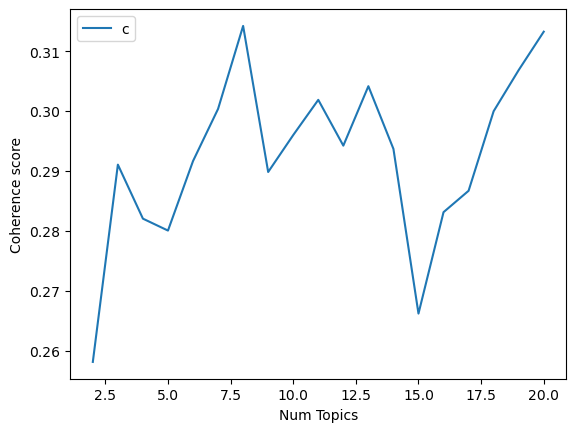

Optimal number of topics:  8


In [40]:
models_list, coherence_scores = find_optimal_number_of_topics(data=corpus_sample,
                                                              dictionary=dictionary,
                                                              preprocessed_docs=preprocessed_docs,
                                                              start=2,
                                                              end=20,
                                                              step=1,
                                                              coherence_measure='c_v',
                                                              coherence_topn=10,
                                                              workers=4)

## Creación de corpus TF-IDF

Este paso es opcional. El modelo se podría tarabajar directamente con el corpus_sample creado anteriormente. Sin embargo, se recomienda utilizar TF-IDF para mejorar la calidad del modelo.

In [52]:
from gensim.models import TfidfModel
tfidf_model = TfidfModel(corpus_sample)
corpus_tfidf = list(tfidf_model[corpus_sample])

# Modelo LDA Optimizado

In [53]:
## La librería cupy permite acelerar el procesamiento en GPU, sin embargo solo trabaja con versiones de python inferiores a 3.10 (la que estoy utilizando) Se sugiere utilizar esto cuando vayamos aumentando el tamñaño del corpus. Para eso el corpus debe convertirse en un array de cupy.

#import cupy as cp
from gensim.models import LdaMulticore

# Establecer el número de núcleos a utilizar
num_cores = 6

# Experimentar con diferentes valores de chunksize
chunk_sizes = [1000, 5000, 10000]
chunk_size = chunk_sizes[0]
for cs in chunk_sizes:
    if len(list(corpus_sample)) / cs > num_cores:
        chunk_size = cs
        break

# Ajustar alpha y eta en función del tipo de corpus y los objetivos del modelo
alpha = 0.1
eta = 0.5

# Utilizar cupy para acelerar el procesamiento en GPU
#cp.cuda.Device(0).use()
#corpus_cupy = cp.array(corpus_sample)

num_topics = 8

# Entrenar el modelo LDA con los parámetros optimizados
lda_model_8 = LdaMulticore(corpus=corpus_tfidf,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         workers=num_cores,
                         chunksize=chunk_size,
                         alpha=alpha,
                         eta=eta,
                         per_word_topics=True,
                         minimum_probability=0.001,
                         minimum_phi_value=0.001)

## Visualización del modelo LDA

In [54]:
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(lda_model_8, list(corpus_sample), dictionary)

pyLDAvis.save_html(LDA_visualization, 'lda_8.HTML')
#LDA_visualization

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Método para incluir bigramas y trigramas en el modelo

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:

tokenized_docs = list(iter_dataframe(datos_sample, 'Detalle_Objeto_Contratar'))

In [ ]:
bigram_phrases = Phrases(tokenized_docs, min_count=5, threshold=10)
bigram_model = Phraser(bigram_phrases)

In [ ]:
bigram_docs = [bigram_model[doc] for doc in tokenized_docs]

In [55]:
trigram_phrases = Phrases(bigram_docs, min_count=5, threshold=10)
trigram_model = Phraser(trigram_phrases)

NameError: name 'Phrases' is not defined

In [ ]:
trigram_docs = [trigram_model[doc] for doc in bigram_docs]

In [ ]:
# Crear un nuevo diccionario utilizando bigram_docs
bigram_dictionary = corpora.Dictionary(bigram_docs)


# Crear un nuevo corpus utilizando bigram_docs y el nuevo diccionario
bigram_corpus = MyCorpus_sample(bigram_dictionary, datos_sample, 'Detalle_Objeto_Contratar')

## Ejemplo de modelo con bigramas

In [ ]:

start = time.time()

# Modelo Simple
lda_model = LdaMulticore(bigram_corpus, num_topics=2, id2word=bigram_dictionary, passes=10, workers=4)

top_topics = lda_model.top_topics(bigram_corpus)
num_topics=2

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

# Función para visualizar los tópicos con perplejidad

In [ ]:
def find_optimal_number_of_topics_perplexity(data, dictionary, start=2, end=20, step=1, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA utilizando la medida de perplejidad.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - Un gráfico de línea que muestra la medida de perplejidad del modelo para cada valor de num_topics evaluado.
    """

    perplexity_scores = []
    models_list = []

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 workers=workers)

        perplexity_lda = lda_model.log_perplexity(data)
        perplexity_scores.append(perplexity_lda)
        models_list.append(lda_model)

    # Plot perplexity scores
    x = range(start, end+1, step)
    plt.plot(x, perplexity_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(("perplexity_values"), loc='best')
    plt.show()

    # Find the optimal number of topics
    optimal_num_topics = x[perplexity_scores.index(min(perplexity_scores))]

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the models list and perplexity scores
    return models_list, perplexity_scores